# Introduction

#### Dataset
dataset sintetis yang dihasilkan menggunakan simulator yang disebut PaySim sebagai pendekatan untuk masalah seperti itu. PaySim menggunakan data agregat dari kumpulan data pribadi untuk menghasilkan kumpulan data sintetis yang menyerupai operasi normal transaksi dan menyuntikkan perilaku berbahaya untuk kemudian mengevaluasi kinerja metode deteksi penipuan.

#### Sumber dataset
Dataset berasal dari kaggle dengan link https://www.kaggle.com/ealaxi/paysim1

#### Objectivitas
Melakukan Feature Engineering dengan menggunakan Gaussian Mixture untuk mendeteksi anomaly pada transaksi financial

#### Features Atribute
- step = Maps a unit of time in the real world. In this case 1 step is 1 hour of time.
- type = CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
- amount = amount of the transaction in local currency
- nameOrig = customer who started the transaction 
- oldbalanceOrg = customer's balance after the transaction.
- newbalanceOrig = customer's balance after the transaction.
- nameDest = recipient ID of the transaction.
- oldbalanceDest = initial recipient balance before the transaction.
- newbalanceDest = recipient's balance after the transaction.
- isFraud = identifies a fraudulent transaction (1) and non fraudulent (0)
- isFlaggedFraud = flags illegal attempts to transfer more than 200.000 in a single transaction. 

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

%matplotlib inline

# Load Data

In [2]:
df = pd.read_csv("financial_dataset.csv")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
df.shape

(6362620, 11)

In [7]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Exploratory Data Analysis

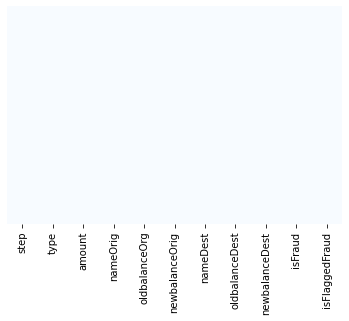

In [8]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues" );

dataset tidak memiliki missing values

# Feature Engineering

## Membuat Anomaly Detection

In [9]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [10]:
col_to_use = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

dataset = df.copy()
dataset = dataset[col_to_use]

In [11]:
dataset

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,9839.64,170136.00,160296.36,0.00,0.00
1,1864.28,21249.00,19384.72,0.00,0.00
2,181.00,181.00,0.00,0.00,0.00
3,181.00,181.00,0.00,21182.00,0.00
4,11668.14,41554.00,29885.86,0.00,0.00
...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13
6362616,6311409.28,6311409.28,0.00,0.00,0.00
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11
6362618,850002.52,850002.52,0.00,0.00,0.00


#### Menentukan Variabel data

In [12]:
X = dataset
X

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,9839.64,170136.00,160296.36,0.00,0.00
1,1864.28,21249.00,19384.72,0.00,0.00
2,181.00,181.00,0.00,0.00,0.00
3,181.00,181.00,0.00,21182.00,0.00
4,11668.14,41554.00,29885.86,0.00,0.00
...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13
6362616,6311409.28,6311409.28,0.00,0.00,0.00
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11
6362618,850002.52,850002.52,0.00,0.00,0.00


#### Mendefinisikan dan melatih model GaussianMixture

In [13]:
model = GaussianMixture(n_components=2)

%time model.fit(X)

CPU times: user 2min 45s, sys: 1min 6s, total: 3min 52s
Wall time: 4min 22s


GaussianMixture(n_components=2)

#### Evaluasi Model

In [14]:
labels = model.predict(X)

In [27]:
df['Anomaly'] = labels
df['Anomaly'].value_counts()

1    4114727
0    2247893
Name: Anomaly, dtype: int64

In [28]:
percentage = len(df[df['Anomaly']== 0])/len(df['Anomaly'])
percentage

0.35329675511031616

#### Visualisasi Model GaussianMixture

In [17]:
pca = PCA(n_components=2)
pca.fit(X)
X_PCA = pca.transform(X)

In [29]:
scores = model.score_samples(X)

thresh = np.quantile(scores, percentage)
print(thresh)

index = np.where(scores <= thresh)
outliers = X_PCA[index]

-75.70623325278046


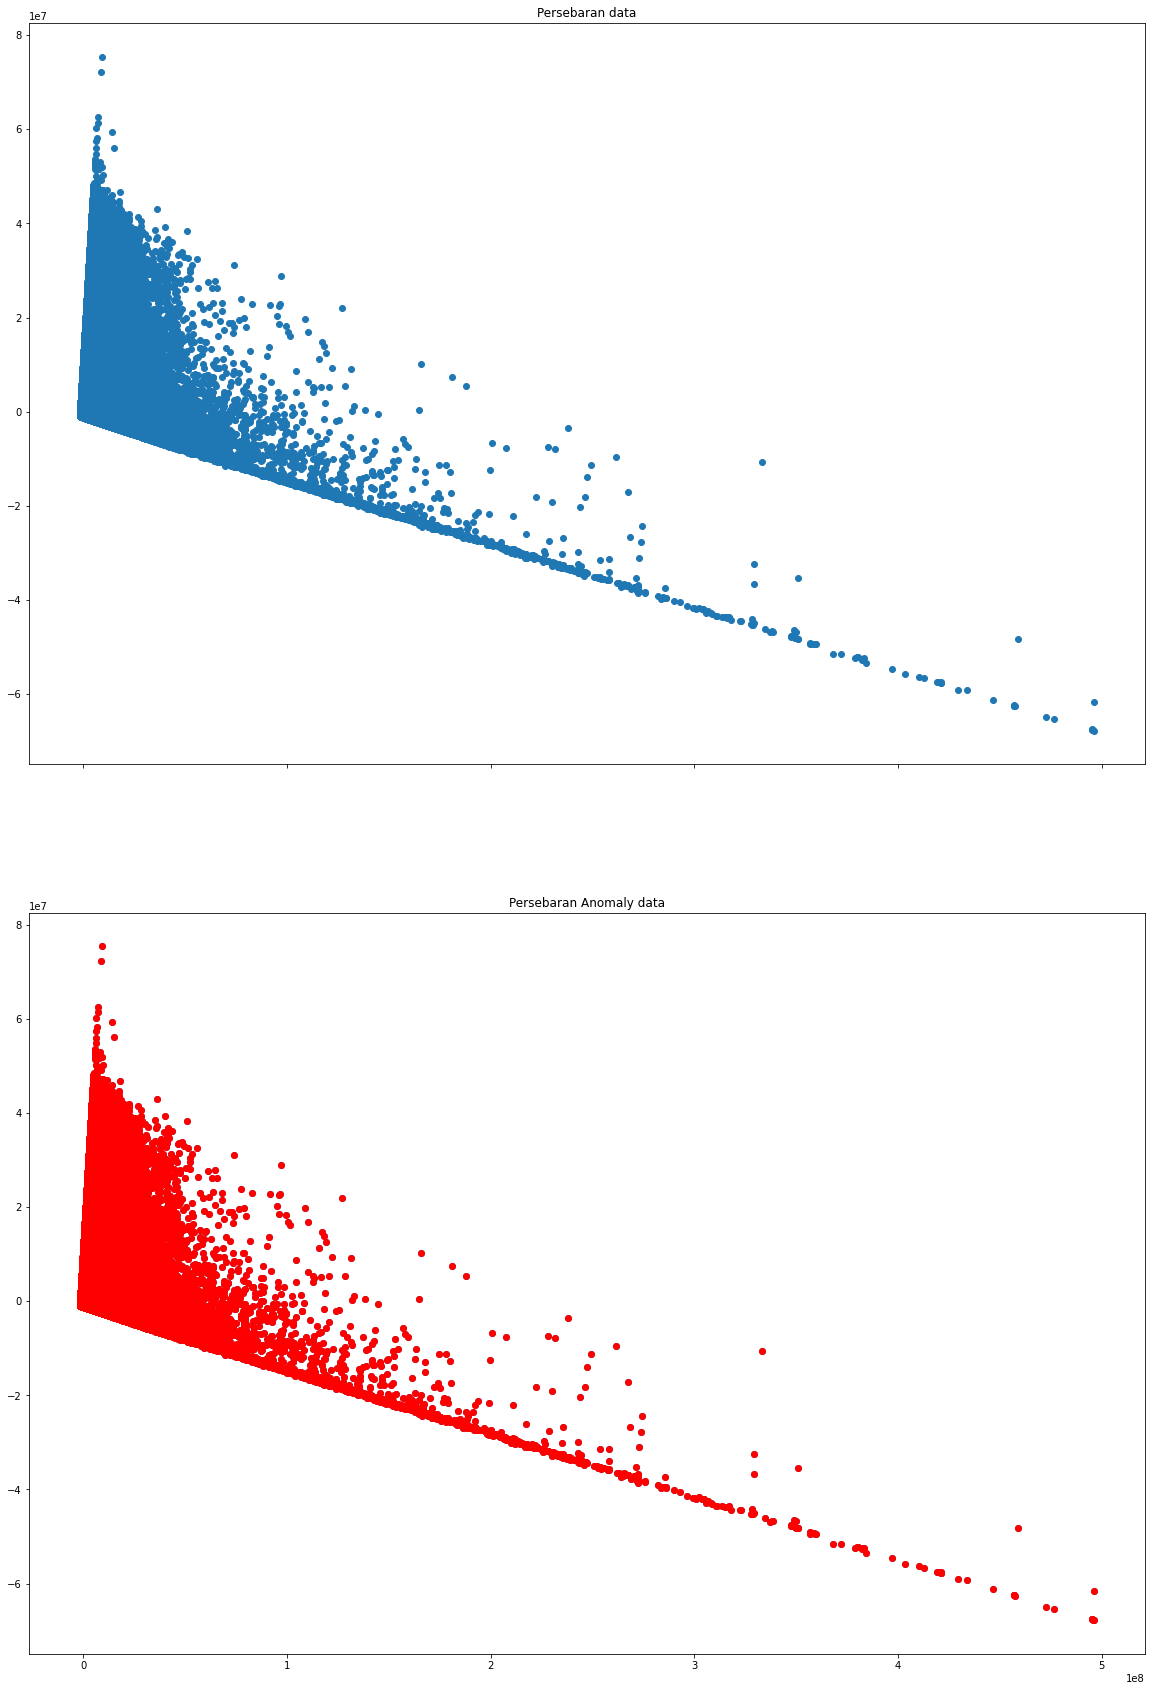

In [30]:
# Subplots of chol, age thalach
fig, (ax0,ax1) = plt.subplots(nrows=2,
                              ncols=1,
                              figsize=(20,30),
                              sharex=True
                              )

# add data to ax0
scatter = ax0.scatter(X_PCA[:, 0], X_PCA[:, 1]);

# customize ax0
ax0.set(title='Persebaran data');


# add data to ax1
scatter = ax1.scatter(X_PCA[:, 0], X_PCA[:,1]);
scatter = ax1.scatter(outliers[:,0],outliers[:,1], color='r');

# customize ax1
ax1.set(title='Persebaran Anomaly data');

#### Membuat Label Anomaly

In [31]:
def getAnomaly(label):
  if label == 0:
    return 'anomaly'
  else:
    return "normal"

In [32]:
df['Anomaly'] = df['Anomaly'].apply(getAnomaly)

In [33]:
titles = list(df.columns)
titles

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'nameDest',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'Anomaly',
 'isFraud',
 'isFlaggedFraud']

In [34]:
titles[10],titles[11] = titles[11],titles[10]
titles[9],titles[10] = titles[10],titles[9]
titles[5],titles[6] = titles[6],titles[5]

In [35]:
df = df[titles]
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,Anomaly,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,normal,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,normal,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,normal,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,normal,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0,anomaly,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0,anomaly,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0,anomaly,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0,anomaly,1


#### Save Dataset baru

In [36]:
df.to_csv("new_financial_dataset.csv", index=False)